In [1]:
##Original structure scans each file individually for specific channel to import data,
##    new structure creates a dictionary to refer to, cuts time of get_data() (for 4 data calls) from 30 seconds to .5, but adds 20 seconds
##    to importdata()

from nptdms import TdmsFile as TF

import os
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import datetime
from datetime import timedelta as td
import time
import TDMS_MHD as MHD
%matplotlib inline


class MolyPlots(MHD.TDMS,MHD.TDMS_np):
    def __init__(self, ):
        MHD.TDMS.__init__(self)
        MHD.TDMS_np.__init__(self)

    def get_times(self, ):
        imports = self.imports
        data = self.data
        tracks = self.tracks
        tracks["Time"] = 0
        for string in imports:
            file = imports[string]
            data[string] = file.object("Global", "Time").data
            
        self.data = data
        self.tracks = tracks
        return
        
        ##Fills the data dictionary with initial arrays of time, to stack with other data in future
    
    def get_motor(self,):
        motortrack = "motor A"
        #group = "Motors"
        self.get_data(motortrack)
        return
    
        ##Calls motor position from motor A for current set up
        
    def get_tc(self, ):
        tctrack = "T_Sample (Arith. Mean)"
        self.get_data(tctrack)
        ##run get data with thermocouple data from the sample holder    
        return
    
    def get_blackbody(self,):
        tracks = self.tracks
        data = self.data
        
        ct1 = "Color Temp 2-3"
        ct2 = "Color Temp 1-3"
        ct3 = "Color Temp 1-2"
        ctavg = "Avg Color Temp"
        self.get_data(ct1)
        self.get_data(ct2)
        self.get_data(ct3)
        
        tracks["Color Temp Avg."] = len(tracks)
        
        for sample in data:
            temp1 = data[sample][tracks[ct1]]
            temp2 = data[sample][tracks[ct2]]
            temp3 = data[sample][tracks[ct3]]
            ctavg = np.mean(np.vstack((temp1,temp2,temp3)),0)
            self.store_data(sample, ctavg)
            
        self.tracks = tracks
        return
        ##gets all two color temperatures and stores them, then calculates the averages and stores that as well
    
    def align(self, channel="motor A"):
        data = self.data
        tracks = self.tracks
        track = "Init Time"
        
        if track not in tracks:
            for sample in data:
                time = data[sample][tracks["Time"]]
                motor = data[sample][tracks[channel]]
                start = np.where(motor[1:]-motor[:-1]>.2)
                start = start[0][1]
                timerel = np.zeros_like(time)
                for i, val in enumerate(time):
                    timerel[i] = (time[i]-time[start]).total_seconds()
                    if np.isclose(timerel[i],2000, rtol=.0001):
                        self.stop = i
                    if np.isclose(timerel[i],0,rtol=.0001):
                        self.start = i
                self.store_data(sample, timerel)
                
            tracks["Time"] = len(tracks)
            tracks[track] = 0
        self.tracks = tracks
        return
        ##Creates a relative time array, for comparing different samples, and aligns the start time of burning the sample
        ##    with the motors position
        ##In future experiments, the align function might be used with other channels, and is anticipated to be made more general

    def plot_tc(self, rods="all"):
        data = self.data
        
        if rods == "all":
            rods = self.samples
        
        for rod in rods:
            for sample in data:
                if rod in sample:
                    print(sample)
                    self.plot_sometc(sample)
        plt.title("Themocouple Temp. ")
        plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
        return
        
    def plot_alltc(self,):
        data = self.data
        
        for rod in data:
            self.plot_sometc(rod)
        
        return

    def plot_sometc(self, rod):
        data = self.data
        tracks = self.tracks
        track = "T_Sample (Arith. Mean)"
        plt.ylabel("Temperatue (C)")
        plt.xlabel("Time (s)")
        for sample in self.samples:
            if sample in rod:
                name = sample
        plt.plot(data[rod][tracks['Time']], data[rod][tracks[track]], label = name)
        return
    


E:\MolyData\MolyD\13mm_together.tdms


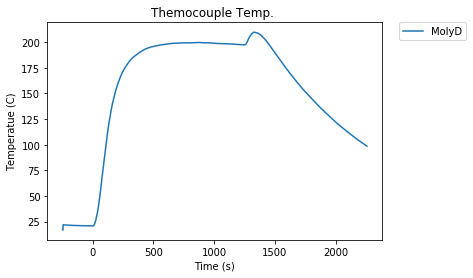

In [2]:
a = MolyPlots()
a.set_pathnames("E:\\MolyData", "*_together.tdms")
a.import_data("13mm_together.tdms")
a.createref()
a.get_times()
a.get_motor()
a.get_tc()
a.get_blackbody()
a.align()
a.plot_tc()

In [3]:
print(a.tracks)

{'Time': 7, 'motor A': 1, 'T_Sample (Arith. Mean)': 2, 'Color Temp 2-3': 3, 'Color Temp 1-3': 4, 'Color Temp 1-2': 5, 'Color Temp Avg.': 6, 'Init Time': 0}
